In [1]:
from typing import List
import sys
from collections import defaultdict

import pandas as pd
import numpy as np
from tqdm.autonotebook import tqdm

from recsys4daos.models import OpenPop
from recsys4daos.datasets import to_microsoft
from recsys4daos.model_selection import cvtt_open
from recsys4daos.evaluation import calculate_all_metrics

import paths

import recommenders
if recommenders.__version__ == '1.2.0':
    print("Ignoring warnings")
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)

/tmp/ipykernel_481539/2526015065.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Ignoring warnings


In [2]:
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
ORG_NAME = 'Decentraland'
LAST_FOLD_DATE_STR: str = None # Won't use it, we will just calculate for every fold

# In this notebook this is just used for plotting and description, not "training"
# every fold is saved into the results table
LAST_FOLDS = 10

K_RECOMMENDATIONS: List[int] = [1,3,5,10,15,100]

In [3]:
# Parameters
EXECUTION_ID = "2024-09-04T10:00"
ORG_NAME = "Aura Finance"
SPLITS_FREQ = "7d"
LAST_FOLDS = 10
SPLITS_NORMALIZE = True
LAST_FOLD_DATE_STR = None


## Obtain dataset

In [4]:
!pwd

/home/daviddavo/recsys4daos/notebooks


In [5]:
!md5sum ../data/decentraland/*

md5sum: '../data/decentraland/*': No such file or directory


In [6]:
dfp = paths.load_proposals(ORG_NAME)
dfv = paths.load_votes(ORG_NAME)

df = to_microsoft(dfv)

print(dfp.info())
print(dfv.info())
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 415 entries, 0 to 414
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 415 non-null    object        
 1   author             415 non-null    object        
 2   date               415 non-null    datetime64[us]
 3   start              415 non-null    datetime64[us]
 4   end                415 non-null    datetime64[us]
 5   platform_proposal  415 non-null    object        
dtypes: datetime64[us](3), object(3)
memory usage: 19.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7677 entries, 0 to 7676
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        7677 non-null   object        
 1   proposal  7677 non-null   object        
 2   voter     7677 non-null   object        
 3   date      7677 non-null   datetime64[us]
dtypes: d

## Showing some info of the folds

In [7]:
sdd = defaultdict(list)

for dftrain, dftest, t, openproposals in cvtt_open(to_microsoft(dfv), SPLITS_FREQ, dfp.reset_index(), remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE):
    dftrain_filter = dftrain[dftrain['itemID'].isin(openproposals)]
    
    sdd['fold'].append(t)
    sdd['open proposals'].append(len(openproposals))
    
    sdd['proposals in train'].append(dftrain['itemID'].nunique())
    sdd['votes in train'].append(len(dftrain))
    sdd['votes in open proposals (train)'].append(len(dftrain_filter))
    sdd['users in open proposals (train)'].append(dftrain_filter['userID'].nunique())
    sdd['votes in test'].append(len(dftest))
    sdd['users in train'].append(dftrain['userID'].nunique())
    sdd['users in test'].append(dftest['userID'].nunique())

sdf_all = pd.DataFrame(sdd).set_index('fold')
sdf_all['vpp in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['open proposals']
sdf_all['vpu in open proposals (train)'] = sdf_all['votes in open proposals (train)'] / sdf_all['users in open proposals (train)']
sdf_all['vpp test'] = sdf_all['votes in test'] / sdf_all['open proposals']
sdf_all['vpu test'] = sdf_all['votes in test'] / sdf_all['users in test']
paths.save_folds_info(sdf_all, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
sdf = sdf_all.tail(LAST_FOLDS)
print(sdf['votes in train'])
_style = sdf[['open proposals', 'votes in open proposals (train)', 'users in open proposals (train)', 'vpp in open proposals (train)', 'vpu in open proposals (train)', 'votes in test', 'users in test', 'vpp test', 'vpu test']].style
_style = _style.format_index('{:%G-W%V}').format(precision=2)
_style

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aura Finance/baseline/folds-info_7d_normalize.parquet
fold
2023-05-12    7022
2023-05-19    7110
2023-05-26    7175
2023-06-02    7235
2023-06-09    7293
2023-06-16    7339
2023-06-23    7428
2023-06-30    7511
2023-07-07    7565
2023-07-14    7602
Name: votes in train, dtype: int64


,open proposals,votes in open proposals (train),users in open proposals (train),vpp in open proposals (train),vpu in open proposals (train),votes in test,users in test,vpp test,vpu test
fold,,,,,,,,,
2023-W19,8,1,1,0.12,1.00,46,17,5.75,2.71
2023-W20,12,27,4,2.25,6.75,61,12,5.08,5.08
2023-W21,10,4,2,0.40,2.00,53,13,5.30,4.08
2023-W22,8,7,1,0.88,7.00,52,14,6.50,3.71
2023-W23,6,2,2,0.33,1.00,43,12,7.17,3.58
2023-W24,14,3,2,0.21,1.50,54,11,3.86,4.91
2023-W25,10,0,0,0.00,nan,79,11,7.90,7.18
2023-W26,7,1,1,0.14,1.00,53,11,7.57,4.82
2023-W27,4,0,0,0.00,nan,37,17,9.25,2.18


In [8]:
print(_style
  .format_index("\\textbf{{{}}}", escape="latex", axis=1)
  .to_latex()
)

\begin{tabular}{lrrrrrrrrr}
 & \textbf{open proposals} & \textbf{votes in open proposals (train)} & \textbf{users in open proposals (train)} & \textbf{vpp in open proposals (train)} & \textbf{vpu in open proposals (train)} & \textbf{votes in test} & \textbf{users in test} & \textbf{vpp test} & \textbf{vpu test} \\
fold &  &  &  &  &  &  &  &  &  \\
2023-W19 & 8 & 1 & 1 & 0.12 & 1.00 & 46 & 17 & 5.75 & 2.71 \\
2023-W20 & 12 & 27 & 4 & 2.25 & 6.75 & 61 & 12 & 5.08 & 5.08 \\
2023-W21 & 10 & 4 & 2 & 0.40 & 2.00 & 53 & 13 & 5.30 & 4.08 \\
2023-W22 & 8 & 7 & 1 & 0.88 & 7.00 & 52 & 14 & 6.50 & 3.71 \\
2023-W23 & 6 & 2 & 2 & 0.33 & 1.00 & 43 & 12 & 7.17 & 3.58 \\
2023-W24 & 14 & 3 & 2 & 0.21 & 1.50 & 54 & 11 & 3.86 & 4.91 \\
2023-W25 & 10 & 0 & 0 & 0.00 & nan & 79 & 11 & 7.90 & 7.18 \\
2023-W26 & 7 & 1 & 1 & 0.14 & 1.00 & 53 & 11 & 7.57 & 4.82 \\
2023-W27 & 4 & 0 & 0 & 0.00 & nan & 37 & 17 & 9.25 & 2.18 \\
2023-W28 & 15 & 0 & 0 & 0.00 & nan & 75 & 10 & 5.00 & 7.50 \\
\end{tabular}



## Running openpop baseline

In [9]:
WARNING_AT_LEAST_OPEN = 5

folds = list(cvtt_open(df, SPLITS_FREQ, dfp, remove_not_in_train_col='userID', normalize=SPLITS_NORMALIZE))
metrics = []
perfectmetrics = []

first_empty = True
ok_in_a_row = best_in_a_row = 0
max_ok_in_a_row = (-1, folds[-1].end)
for i, (train, test, t, open_proposals) in enumerate(tqdm(folds)):   
    if first_empty:
        if not train.empty:
            first_empty = False
    else:
        assert not train.empty, f"Train should not be empty on fold {i}"
    if test.empty:
        print(f"Warning, empty test fold {i} ({t}), all ok since {ok_in_a_row} folds ago", file=sys.stderr)
        ok_in_a_row = best_in_a_row = 0
    elif len(open_proposals) < WARNING_AT_LEAST_OPEN:
        print(f"Warning, test fold {i} ({t}) with less than {WARNING_AT_LEAST_OPEN} open proposals ({len(open_proposals)}). all ok since {best_in_a_row} folds ago", file=sys.stderr)
        best_in_a_row = 0

    mdict = {'fold': t}
    pdict = {'fold': t}
    model = OpenPop(train)
    recs = model.recommend_k_items(test['userID'].unique(), max(K_RECOMMENDATIONS), recommend_from=open_proposals)
    mdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)
        # for m, f in metrics_f.items():
        #     r = f(test, recs, k=k_recs)
        #     metrics[m+f'@{k_recs}'].append(r)
    
    recs = test.copy()
    recs['prediction'] = 1
    pdict |= calculate_all_metrics(test, recs, K_RECOMMENDATIONS)

        # for m, f in metrics_f.items():
        #     # Need relevancy_method=None as they are unsorted
        #     r = f(test, recs, k=k_recs)
        #     perfectmetrics[m+f'@{k_recs}'].append(r)

    metrics.append(mdict)
    perfectmetrics.append(pdict)
    ok_in_a_row += 1
    best_in_a_row += 1

    if ok_in_a_row > max_ok_in_a_row[0]:
        max_ok_in_a_row = (ok_in_a_row, t)

paths.save_dao_datum(ORG_NAME, 'max_ok_folds', str(max_ok_in_a_row[0]))
paths.save_dao_datum(ORG_NAME, 'max_ok_folds_date', str(max_ok_in_a_row[1]))
if max_ok_in_a_row[0] == -1:
    print("All ok :>")
else:
    print("Max ok in a row:", max_ok_in_a_row)

  0%|          | 0/57 [00:00<?, ?it/s]

Warning, empty test fold 0 (2022-06-17 00:00:00), all ok since 0 folds ago
Warning, test fold 1 (2022-06-24 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 2 (2022-07-01 00:00:00), all ok since 2 folds ago
Warning, test fold 3 (2022-07-08 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 4 (2022-07-15 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 6 (2022-07-29 00:00:00), all ok since 4 folds ago
Warning, test fold 7 (2022-08-05 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, empty test fold 8 (2022-08-12 00:00:00), all ok since 2 folds ago
Warning, test fold 9 (2022-08-19 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 10 (2022-08-26 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, test fold 11 (2022-09-02 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 12 (2022-09-09 00:00:00), all ok since 4 folds ago
Warning, test fold 13 (2022-09-16 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 14 (2022-09-23 00:00:00), all ok since 2 folds ago
Warning, test fold 15 (2022-09-30 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 16 (2022-10-07 00:00:00), all ok since 2 folds ago
Warning, test fold 17 (2022-10-14 00:00:00) with less than 5 open proposals (1). all ok since 1 folds ago


Warning, empty test fold 18 (2022-10-21 00:00:00), all ok since 2 folds ago
Warning, test fold 19 (2022-10-28 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 20 (2022-11-04 00:00:00), all ok since 2 folds ago
Warning, test fold 21 (2022-11-11 00:00:00) with less than 5 open proposals (2). all ok since 1 folds ago


Warning, empty test fold 22 (2022-11-18 00:00:00), all ok since 2 folds ago
Warning, test fold 23 (2022-11-25 00:00:00) with less than 5 open proposals (3). all ok since 1 folds ago


Warning, empty test fold 28 (2022-12-30 00:00:00), all ok since 6 folds ago


Warning, test fold 31 (2023-01-20 00:00:00) with less than 5 open proposals (3). all ok since 3 folds ago


Warning, test fold 32 (2023-01-27 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 33 (2023-02-03 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 37 (2023-03-03 00:00:00) with less than 5 open proposals (2). all ok since 4 folds ago


Warning, test fold 38 (2023-03-10 00:00:00) with less than 5 open proposals (4). all ok since 1 folds ago


Warning, test fold 55 (2023-07-07 00:00:00) with less than 5 open proposals (4). all ok since 17 folds ago


Max ok in a row: (29, Timestamp('2023-07-14 00:00:00'))


### Caching these results

In [10]:
odf = pd.DataFrame(metrics).set_index("fold")
paths.save_openpop(odf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
odf.describe()

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aura Finance/baseline/openpop_7d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.499973,0.293307,0.221094,0.137573,0.099622,0.014943,0.498215,0.514397,0.516318,0.514919,...,0.541685,0.556971,0.556971,0.384204,0.462256,0.495125,0.523403,0.531184,0.531184,0.113891
std,0.410228,0.239861,0.207633,0.158133,0.126131,0.018920,0.409543,0.415596,0.420558,0.423817,...,0.450548,0.462129,0.462129,0.386883,0.408838,0.417760,0.424875,0.428991,0.428991,0.031425
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068796
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073502
50%,0.558140,0.333333,0.200000,0.100000,0.066667,0.010000,0.558140,0.626188,0.660734,0.661599,...,0.743186,0.823438,0.823438,0.237415,0.420576,0.510000,0.673214,0.706833,0.706833,0.126719
75%,0.946746,0.480287,0.330769,0.167647,0.111765,0.016765,0.946746,0.966117,0.975230,0.975893,...,1.000000,1.000000,1.000000,0.848148,0.930857,0.967662,0.971098,0.971098,0.971098,0.136376
max,1.000000,0.800000,0.670000,0.600000,0.527132,0.079070,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.166771


In [11]:
pdf = pd.DataFrame(perfectmetrics).set_index("fold")
cols = [ c for c in pdf.columns if not c.startswith('time_') ]
paths.save_perfect(pdf, ORG_NAME, SPLITS_FREQ, SPLITS_NORMALIZE)
display(pdf.describe())
msk = (0 <= pdf[cols].min()) & (pdf[cols].max() <= 1)
if not all(msk):
    display(pdf.describe()[msk[~msk].index])
assert all( msk ), "There are metrics with wrong range"

Saved dataframe into /home/daviddavo/recsys4daos/data/output/Aura Finance/baseline/perfect_7d_normalize.parquet


,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,ndcg@10,...,recall@10,recall@15,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval
count,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000
mean,0.807018,0.509527,0.403767,0.263296,0.186528,0.027979,0.807018,0.807018,0.807018,0.807018,...,0.794444,0.807018,0.807018,0.505557,0.661487,0.732283,0.794444,0.807018,0.807018,0.126524
std,0.398147,0.309554,0.282056,0.220998,0.165457,0.024819,0.398147,0.398147,0.398147,0.398147,...,0.393017,0.398147,0.398147,0.337429,0.361514,0.376639,0.393017,0.398147,0.398147,0.027166
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.072580
25%,1.000000,0.333333,0.200000,0.100000,0.066667,0.010000,1.000000,1.000000,1.000000,1.000000,...,0.916084,1.000000,1.000000,0.309457,0.539062,0.716146,0.916084,1.000000,1.000000,0.130267
50%,1.000000,0.551282,0.363636,0.181818,0.121212,0.018182,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.471029,0.771684,0.923077,1.000000,1.000000,1.000000,0.133512
75%,1.000000,0.794872,0.646154,0.418182,0.321212,0.048182,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.842294,0.965074,1.000000,1.000000,1.000000,1.000000,0.141747
max,1.000000,0.969697,0.909091,0.740000,0.600000,0.090000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.168323


## Plotting some graphs

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,57,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,...,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,57.000000,0.0,0.0
mean,2022-12-30 00:00:00,0.499973,0.293307,0.221094,0.137573,0.099622,0.014943,0.498215,0.514397,0.516318,...,0.556971,0.384204,0.462256,0.495125,0.523403,0.531184,0.531184,0.113891,NaN,NaN
min,2022-06-17 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068796,NaN,NaN
25%,2022-09-23 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073502,NaN,NaN
50%,2022-12-30 00:00:00,0.558140,0.333333,0.200000,0.100000,0.066667,0.010000,0.558140,0.626188,0.660734,...,0.823438,0.237415,0.420576,0.510000,0.673214,0.706833,0.706833,0.126719,NaN,NaN
75%,2023-04-07 00:00:00,0.946746,0.480287,0.330769,0.167647,0.111765,0.016765,0.946746,0.966117,0.975230,...,1.000000,0.848148,0.930857,0.967662,0.971098,0.971098,0.971098,0.136376,NaN,NaN
max,2023-07-14 00:00:00,1.000000,0.800000,0.670000,0.600000,0.527132,0.079070,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.166771,NaN,NaN
std,NaN,0.410228,0.239861,0.207633,0.158133,0.126131,0.018920,0.409543,0.415596,0.420558,...,0.462129,0.386883,0.408838,0.417760,0.424875,0.428991,0.428991,0.031425,NaN,NaN


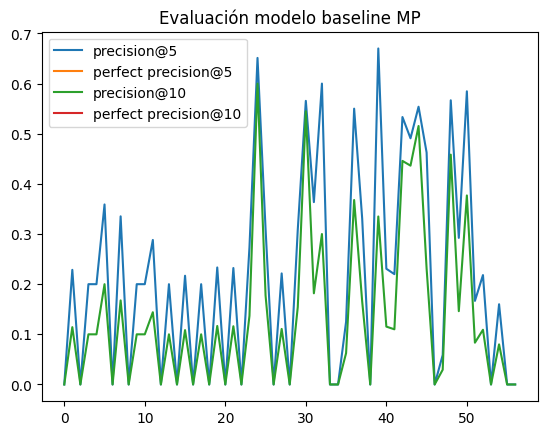

In [12]:
mdf = pd.DataFrame(metrics)
mdf['perfect precision@5'] = pdf['precision@5']
mdf['perfect precision@10'] = pdf['precision@10']
mdf[['precision@5', 'perfect precision@5', 'precision@10', 'perfect precision@10']].plot(title='Evaluación modelo baseline MP')
mdf.describe()

In [13]:
mdf[-LAST_FOLDS:].describe()

,fold,precision@1,precision@3,precision@5,precision@10,precision@15,precision@100,ndcg@1,ndcg@3,ndcg@5,...,recall@100,r-precision@1,r-precision@3,r-precision@5,r-precision@10,r-precision@15,r-precision@100,time_eval,perfect precision@5,perfect precision@10
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.0,0.0
mean,2023-06-12 12:00:00,0.386743,0.243347,0.204726,0.128325,0.087216,0.013082,0.376723,0.324839,0.324252,...,0.350250,0.205890,0.268131,0.306385,0.332853,0.333895,0.333895,0.112550,NaN,NaN
min,2023-05-12 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.073857,NaN,NaN
25%,2023-05-27 18:00:00,0.038462,0.024510,0.014706,0.007353,0.004902,0.000735,0.038462,0.034506,0.026852,...,0.013358,0.025000,0.045417,0.045417,0.045417,0.045417,0.045417,0.088071,NaN,NaN
50%,2023-06-12 12:00:00,0.339367,0.272222,0.163333,0.081667,0.054444,0.008167,0.325630,0.317588,0.310194,...,0.256612,0.167619,0.250595,0.297768,0.297768,0.297768,0.297768,0.126873,NaN,NaN
75%,2023-06-28 06:00:00,0.745833,0.343240,0.273776,0.136888,0.091259,0.013689,0.691288,0.580755,0.614692,...,0.524107,0.258461,0.441518,0.554732,0.587143,0.587143,0.587143,0.129271,NaN,NaN
max,2023-07-14 00:00:00,0.833333,0.589744,0.584615,0.458333,0.322222,0.048333,0.833333,0.714194,0.699209,...,0.979396,0.609524,0.612857,0.612857,0.755258,0.765675,0.765675,0.132081,NaN,NaN
std,NaN,0.350642,0.219578,0.219505,0.161569,0.111555,0.016733,0.341824,0.281884,0.289881,...,0.382364,0.211267,0.225844,0.256397,0.292231,0.293917,0.293917,0.026105,NaN,NaN
